All the imports

In [1]:
import pandas as pd
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
from src.utils.analysis_tools import *


In [2]:
path = "./data/"
filtered_meta = pd.read_csv(path+"final_yt_metadata.csv")

C:\Users\leoga\AppData\Local\Temp\ipykernel_20604\803352734.py:2: DtypeWarning: Columns (4,6,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_meta = pd.read_csv(path+"final_yt_metadata.csv")


12 hours is the limit for livestream uploads


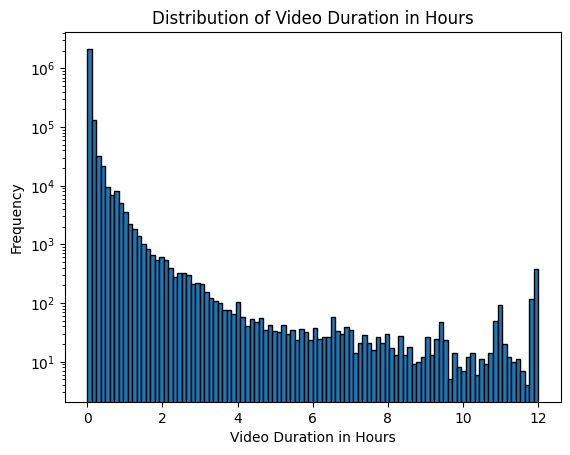

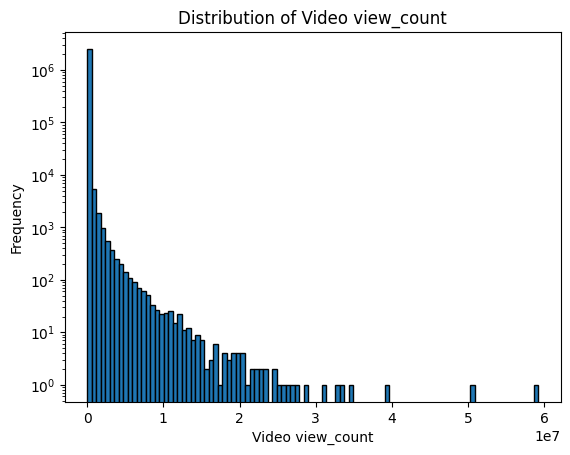

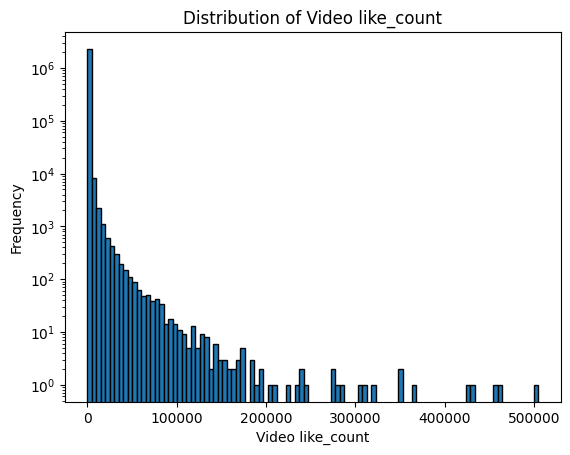

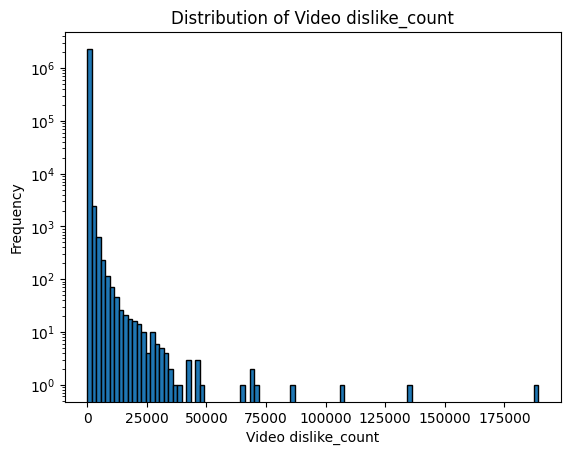

KeyError: "None of [Index([24497, 17096, 13344, 11502, 11240, 10143, 10004,  9938,  9735,  9712,\n       ...\n           1,     1,     1,     1,     1,     1,     1,     1,     1,     1],\n      dtype='int64', length=156883)] are in the [columns]"

In [9]:
plot_video_stat(filtered_meta, 'duration')
plot_video_stat(filtered_meta, 'view_count')
plot_video_stat(filtered_meta, 'like_count')
plot_video_stat(filtered_meta, 'dislike_count')

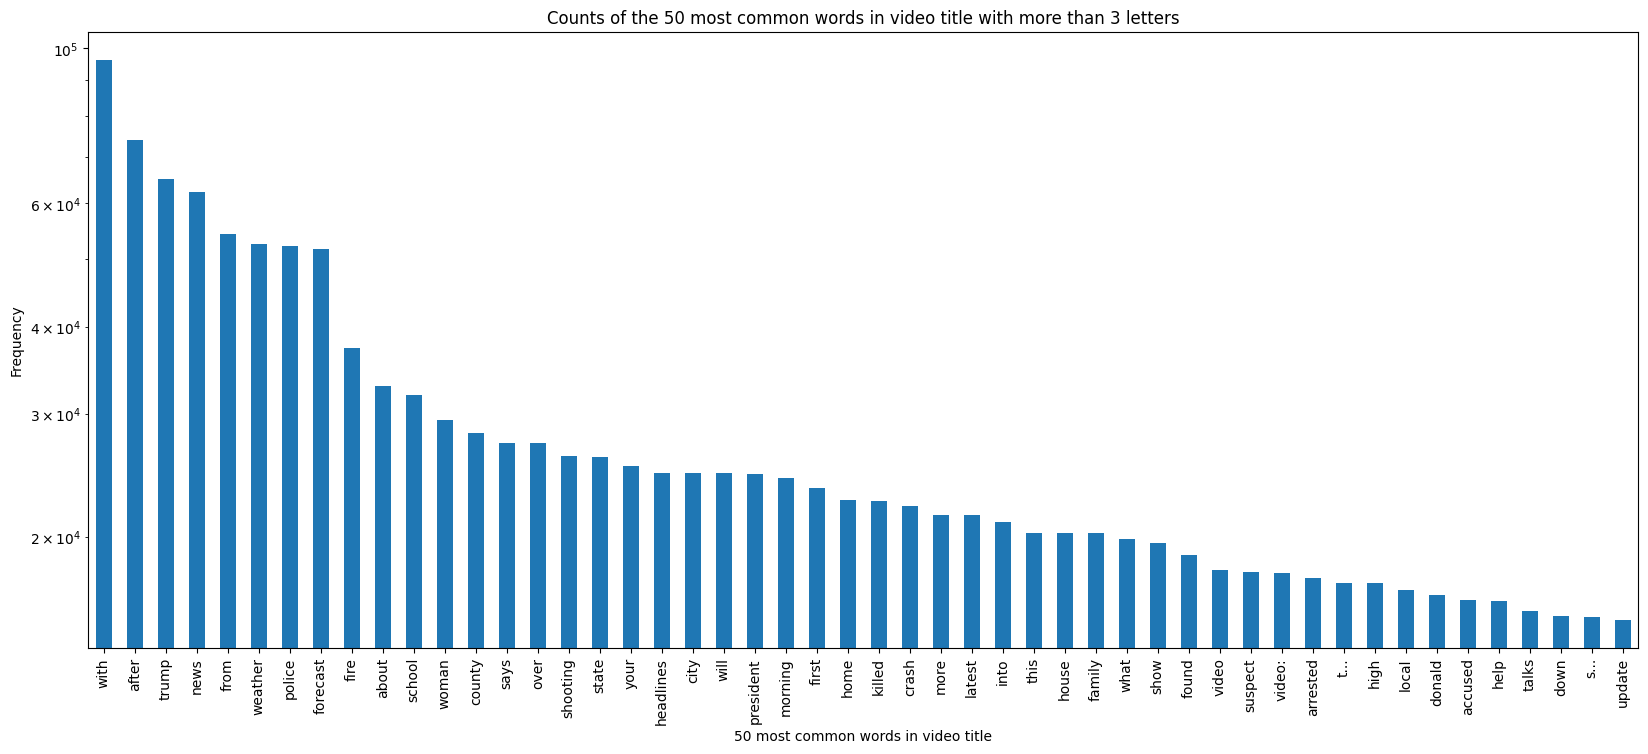

In [4]:
plot_most_common_words(filtered_meta, 'title', 50)


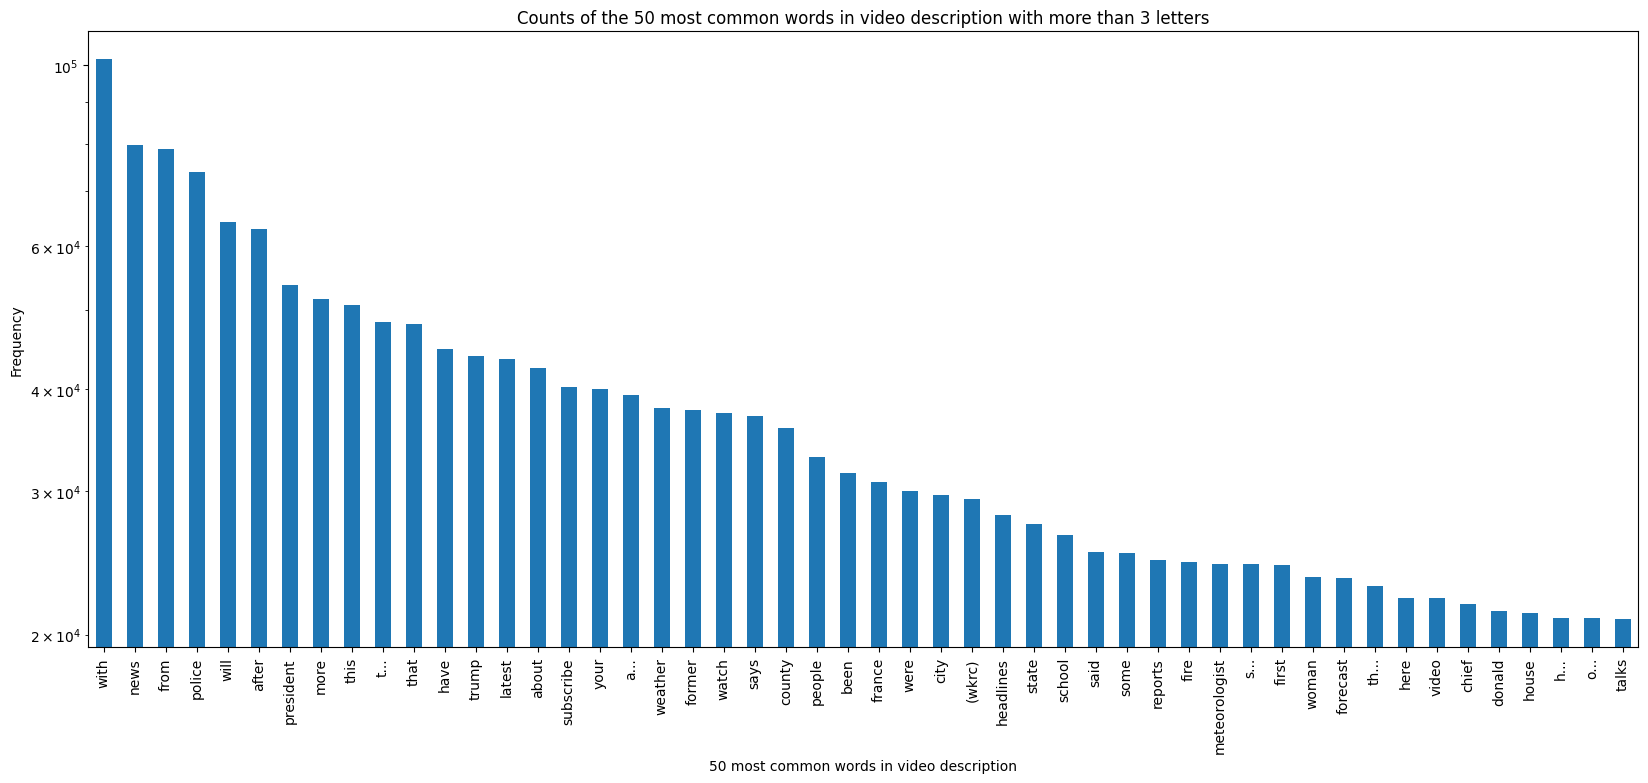

In [5]:
plot_most_common_words(filtered_meta, 'description', 50)

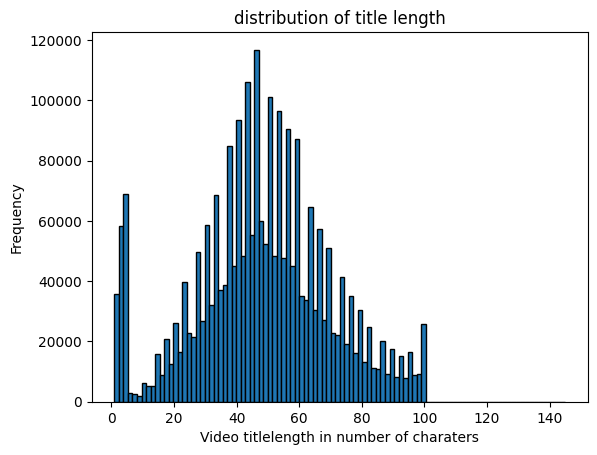

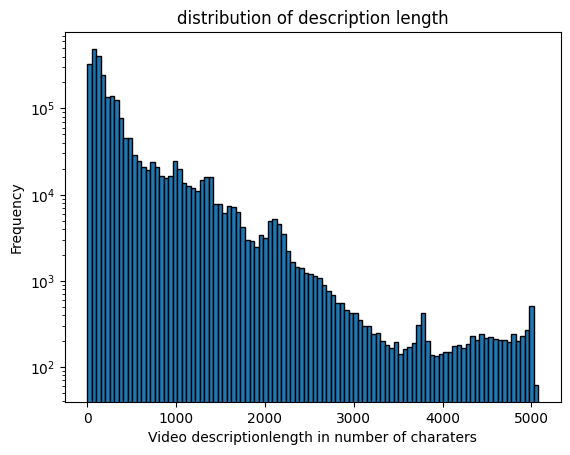

In [6]:
plot_text_len_char(filtered_meta, 'title')
plot_text_len_char(filtered_meta, 'description')

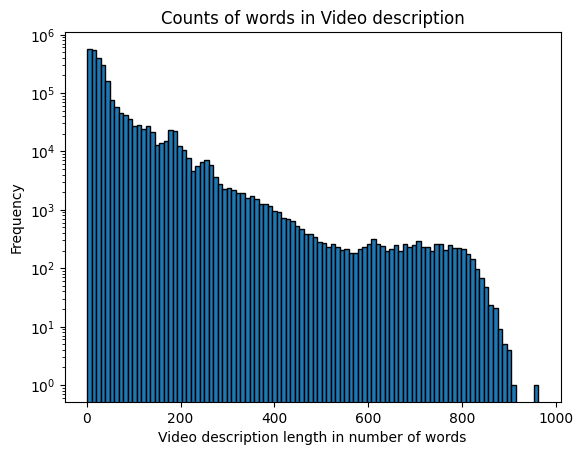

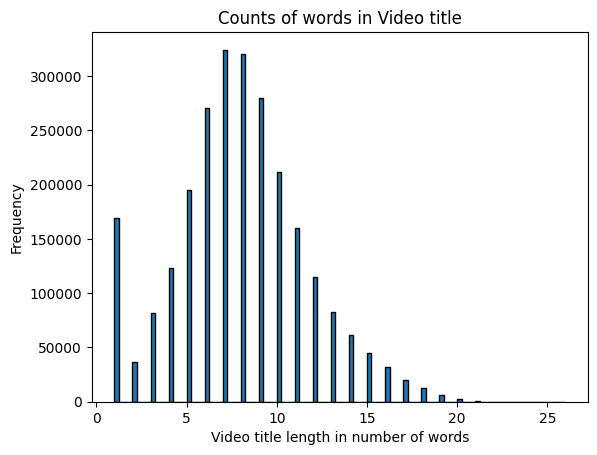

TypeError: '<' not supported between instances of 'str' and 'int'

In [20]:
plot_text_len_words(filtered_meta, 'description')
plot_text_len_words(filtered_meta, 'title')